In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [2]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [3]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

ones = np.ones(x1.shape)
X = torch.from_numpy(np.column_stack((ones,x1)))
X = X.to(torch.float32)
y = torch.from_numpy(y)
y = y.to(torch.float32)

In [4]:
X_T_X = torch.mm(X.T, X)
X_T_y = torch.mm(X.T, y.unsqueeze(1))
optTheta = torch.mm(torch.inverse(X_T_X), X_T_y)
optTheta = optTheta.view(-1)
optTheta

tensor([3.9507, 2.6825])

In [5]:
def true_gradient(X,y,theta):
    theta.requires_grad_(True)
    y_pred = torch.matmul(X,theta)
    loss = torch.mean((y_pred-y)**2)
    loss.backward()
    return theta.grad.detach().clone()

def stochastic_gradient(X,y,theta,num_samples):
    gradients = []
    theta.requires_grad_(True)
    theta.grad.zero_()
    for i in range(num_samples):
        y_pred = torch.matmul(X[i],theta)
        loss = (y_pred-y[i])**2
        loss.backward()
        gradients.append(theta.grad.clone())
        theta.grad.zero_()
    return sum(gradients)/num_samples

In [6]:
for trial in range(5):
    theta = torch.randint(0,10,(2,),dtype = torch.float32)
    True_gradient = true_gradient(X,y,theta)
    Stochastic_gradient = stochastic_gradient(X,y,theta,num_samples) 

    print(f'Trial {trial+1}')
    print(f"Theta Value:       {theta[0]:.4f}, {theta[1]:.4f}")
    print(f"True Gradient:       {True_gradient[0]:.4f}, {True_gradient[1]:.4f}")
    print(f"Stochastic Gradient: {Stochastic_gradient[0]:.4f}, {Stochastic_gradient[1]:.4f}")
    print()


Trial 1
Theta Value:       4.0000, 1.0000
True Gradient:       0.3836, -1.0711
Stochastic Gradient: 0.3836, -1.0711

Trial 2
Theta Value:       5.0000, 3.0000
True Gradient:       2.0448, 0.0228
Stochastic Gradient: 2.0448, 0.0228

Trial 3
Theta Value:       2.0000, 2.0000
True Gradient:       -3.7858, -0.1007
Stochastic Gradient: -3.7858, -0.1007

Trial 4
Theta Value:       8.0000, 5.0000
True Gradient:       7.7060, 0.7781
Stochastic Gradient: 7.7060, 0.7781

Trial 5
Theta Value:       1.0000, 8.0000
True Gradient:       -6.8021, 3.8588
Stochastic Gradient: -6.8021, 3.8588



In [7]:
def true_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,optTheta):
    theta_evolution = []
    loss_tgd = []
    epoch_count = max_epochs
    for epoch in range(max_epochs):
        
        y_pred = torch.matmul(X,theta)
        loss = torch.mean((y_pred - y)**2)
        loss_tgd.append(loss.item())
        loss.backward()
        grad_norm = torch.norm(theta - optTheta)
        if grad_norm < epsilon:
            epoch_count = epoch+1
            break
        theta_evolution.append(theta.clone().detach())

        with torch.no_grad():
            theta -= theta.grad*learning_rate
            theta.grad.zero_()
        
    return theta_evolution,epoch_count,loss_tgd


import torch

def stochastic_gradient_descent(X, y, theta, learning_rate, epsilon, max_epochs, num_samples, optTheta):
    theta_evolution = []
    loss_sgd = []
    epoch_count = max_epochs
    theta.requires_grad_(True)
    
    for epoch in range(max_epochs):
        for i in range(num_samples):
            y_pred = torch.matmul(X[i], theta)
            loss = torch.mean((y_pred - y[i])**2)
            loss_sgd.append(loss.item())
            loss.backward()
            theta_evolution.append(theta.detach().clone())
            with torch.no_grad():
                theta -= learning_rate * theta.grad
                theta.grad.zero_()
            if torch.norm(theta - optTheta) < epsilon:
                epoch_count = epoch + 1
                break
        if torch.norm(theta - optTheta) < epsilon:
            break
    
    return theta_evolution, epoch_count, loss_sgd


import torch

def mini_batch_gradient_descent(X, y, theta, learning_rate, epsilon, max_epochs, num_samples, batch_size, optTheta):
    theta_evolution = []
    loss_mbgd = []
    epoch_count = max_epochs
    num_batches = int(num_samples / batch_size)
    
    theta.requires_grad_(True)
    
    for epoch in range(max_epochs):
        for i in range(num_batches):
            batch_count = i+1
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            y_batch = y[i * batch_size:(i + 1) * batch_size]
            y_pred = torch.matmul(X_batch, theta)
            loss = torch.mean((y_pred - y_batch) ** 2)
            loss_mbgd.append(loss.item())
            loss.backward()
            theta_evolution.append(theta.detach().clone())
            with torch.no_grad():
                theta -= learning_rate * theta.grad
                theta.grad.zero_()  
            if torch.norm(theta - optTheta) < epsilon:
                epoch_count = epoch + 1
                break
        if torch.norm(theta - optTheta) < epsilon:
            break
    
    return theta_evolution,batch_count,epoch_count,loss_mbgd

def gradient_descent_with_momentum(X, y, theta, learning_rate, epsilon, max_epochs, beta,optTheta):
    theta_evolution_gdm = []
    loss_gdm = []
    epoch_count = max_epochs
    velocity = torch.zeros_like(theta)  
    
    for epoch in range(max_epochs):
        y_pred = torch.matmul(X, theta)
        loss = torch.mean((y_pred - y)**2)
        loss_gdm.append(loss.item())
        loss.backward()
        
        grad_norm = torch.norm(theta - optTheta)
        
        if grad_norm < epsilon:
            epoch_count = epoch + 1
            break
        
        theta_evolution_gdm.append(theta.clone().detach())
        
        with torch.no_grad():
            velocity = beta * velocity + (1 - beta) * theta.grad
            theta -= learning_rate * velocity  
            theta.grad.zero_()
    
    return theta_evolution_gdm, epoch_count, loss_gdm


In [22]:
def plot_contours_custom_range(ax, X, y, theta_evolution, optTheta, title):
    theta0_vals = np.linspace(2.,5.5, 200)
    theta1_vals = np.linspace(1, 5.5, 200)
    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)
    J_vals = np.zeros_like(T0)
    for i in range(len(theta0_vals)):
        for j in range(len(theta1_vals)):
            theta_ij = torch.tensor([T0[i, j], T1[i, j]], dtype=torch.float32)
            y_pred = torch.matmul(X, theta_ij)
            J_vals[i, j] = torch.mean((y_pred - y)**2).item()
    heatmap = ax.imshow(J_vals, extent=[theta0_vals.min(), theta0_vals.max(), theta1_vals.min(), theta1_vals.max()],
                        origin='lower', aspect='auto', cmap='jet', alpha=0.75)

    ax.contour(T0, T1, J_vals, levels=np.logspace(-2, 3, 20), cmap='viridis', alpha=0.7)

    theta_evolution = np.array(theta_evolution[:50])
    ax.plot(theta_evolution[:, 0], theta_evolution[:, 1], 'ro-', label='Convergence Path')

    ax.plot(theta_evolution[0, 0], theta_evolution[0, 1], 'go', label='Initial Theta')
    ax.plot(optTheta[0].item(), optTheta[1].item(), 'kx', markersize=10, label='Optimal Theta')

    ax.set_xlabel(r'$\theta_0$', fontsize=10)
    ax.set_ylabel(r'$\theta_1$', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=8)
    ax.grid(True)


def lossvepoch(ax, loss, method_name):
    ax.plot(range(len(loss)), loss, color='blue', linestyle='-', marker='o', markersize=4, label=f'{method_name} Loss')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'Loss vs Epochs ({method_name})', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=8)


def plot_all(X, y, theta_evolution_tgd, theta_evolution_sgd, theta_evolution_mbgd, theta_evolution_gdm,
             loss_tgd, loss_sgd, loss_mbgd, loss_gdm, optTheta):
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))

    plot_contours_custom_range(axes[0, 0], X, y, theta_evolution_tgd, optTheta, 'True Gradient Descent')
    plot_contours_custom_range(axes[0, 1], X, y, theta_evolution_sgd, optTheta, 'Stochastic Gradient Descent')
    plot_contours_custom_range(axes[0, 2], X, y, theta_evolution_mbgd, optTheta, 'Mini-batch Gradient Descent')
    plot_contours_custom_range(axes[0, 3], X, y, theta_evolution_gdm, optTheta, 'Gradient Descent with Momentum')

    lossvepoch(axes[1, 0], loss_tgd, 'True Gradient Descent')
    lossvepoch(axes[1, 1], [loss_sgd[40*i] for i in range(int(len(loss_sgd)/40))], 'Stochastic Gradient Descent')
    lossvepoch(axes[1, 2], [loss_mbgd[8*i] for i in range(int(len(loss_mbgd)/8))], 'Mini-batch Gradient Descent')
    lossvepoch(axes[1, 3], loss_gdm, 'Gradient Descent with Momentum')

    plt.tight_layout()
    plt.show()




In [23]:
max_epochs = 300
learning_rate = 0.05
epsilon = 0.001
batch_size = 5
beta = 0.9




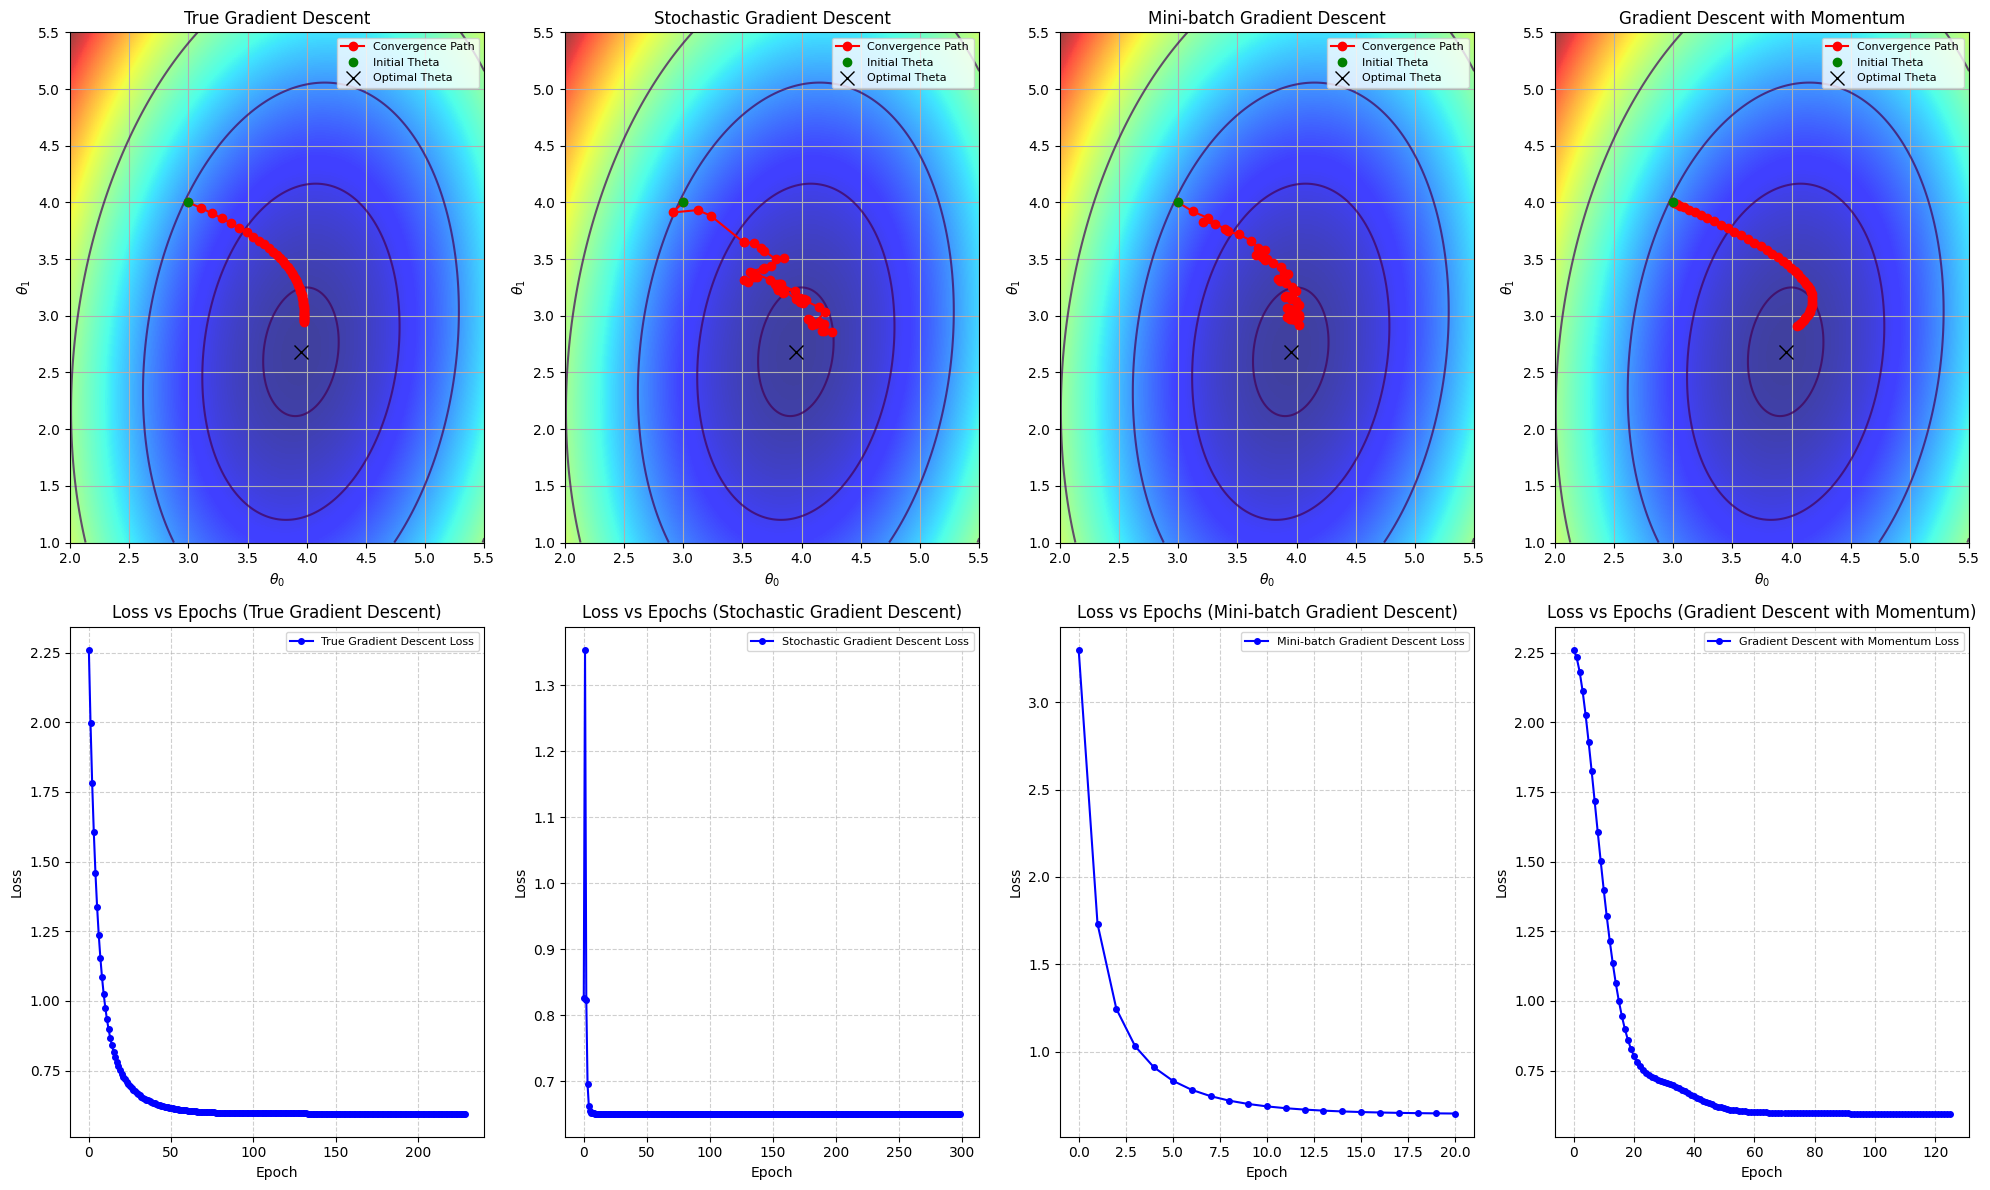

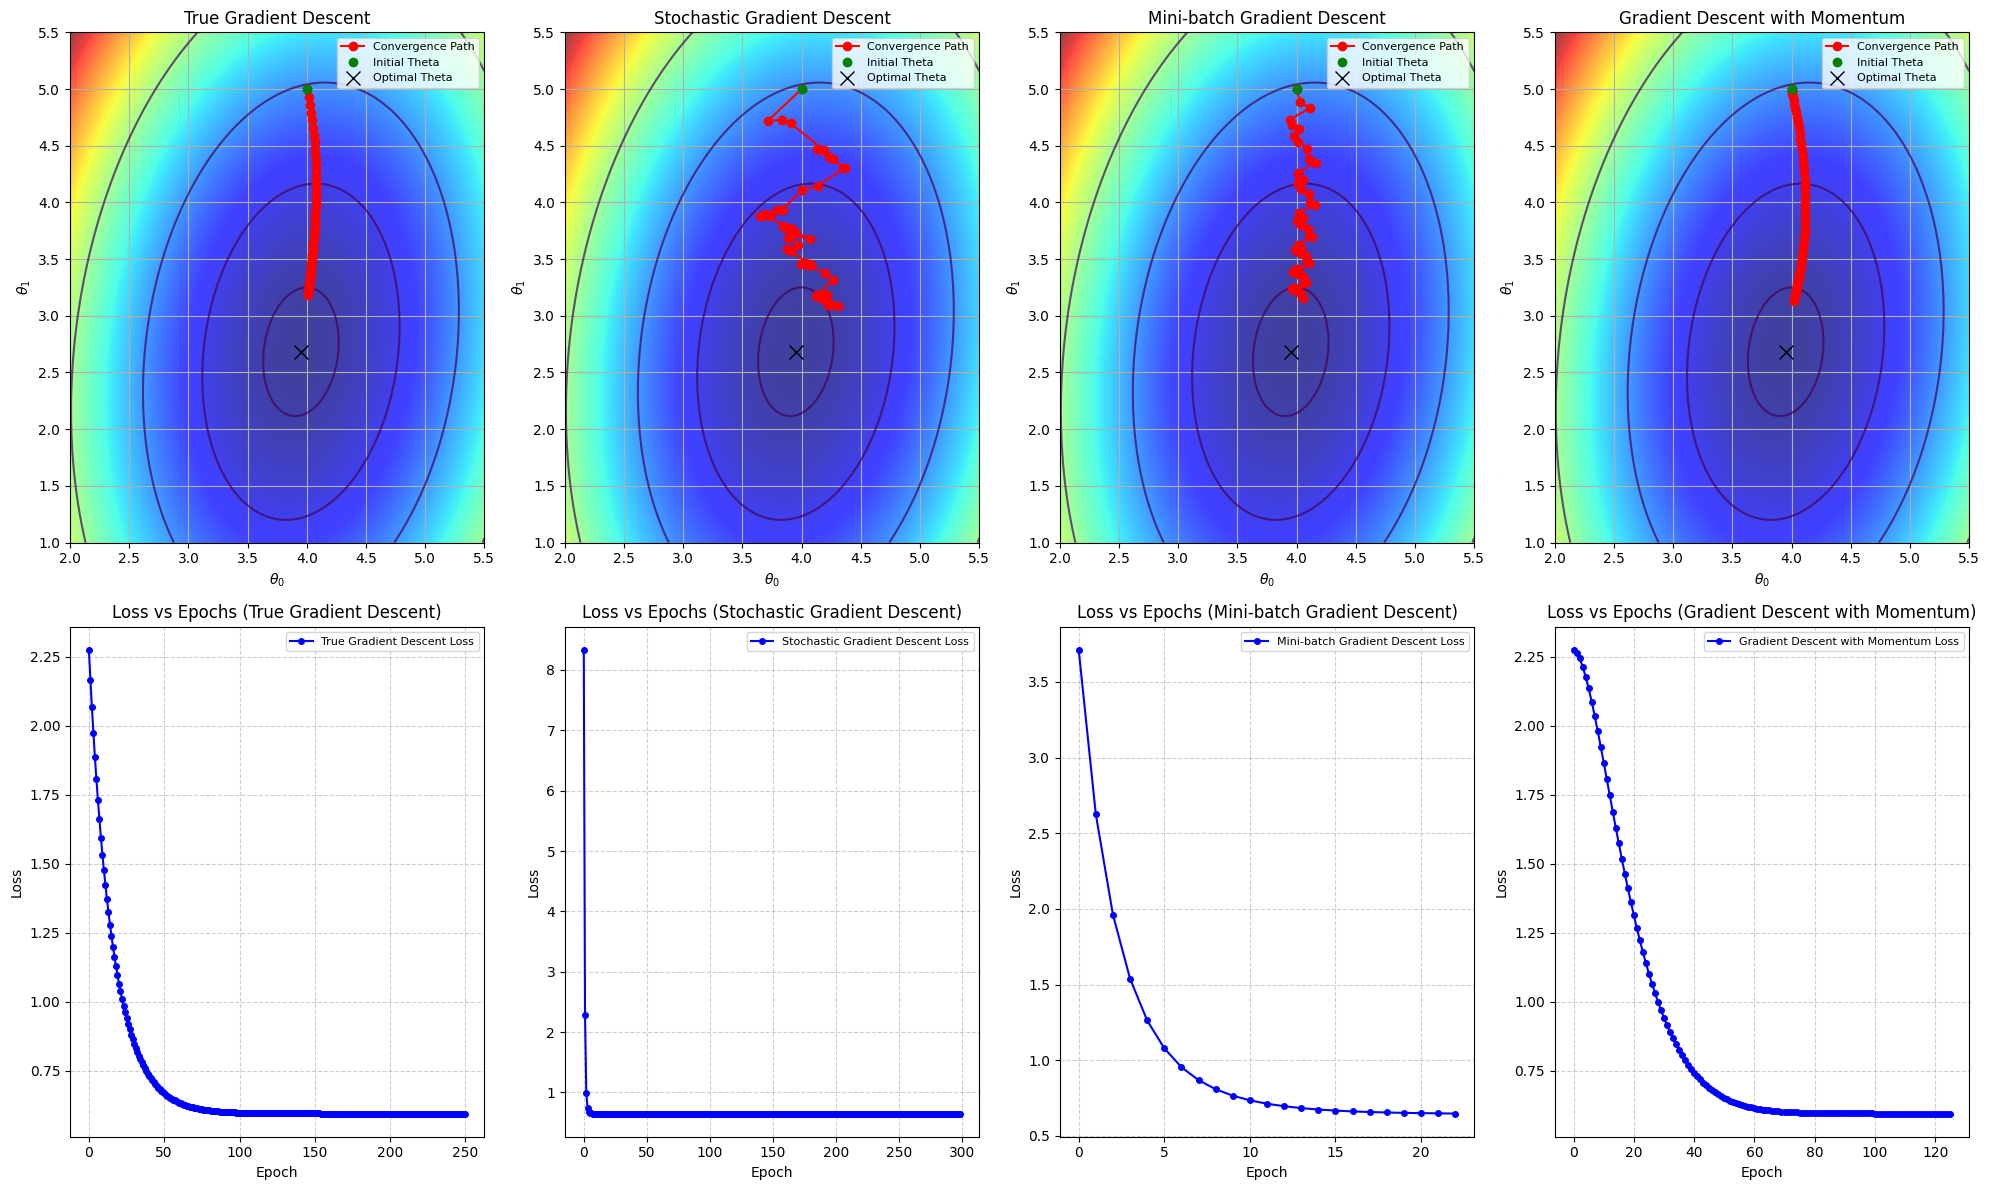

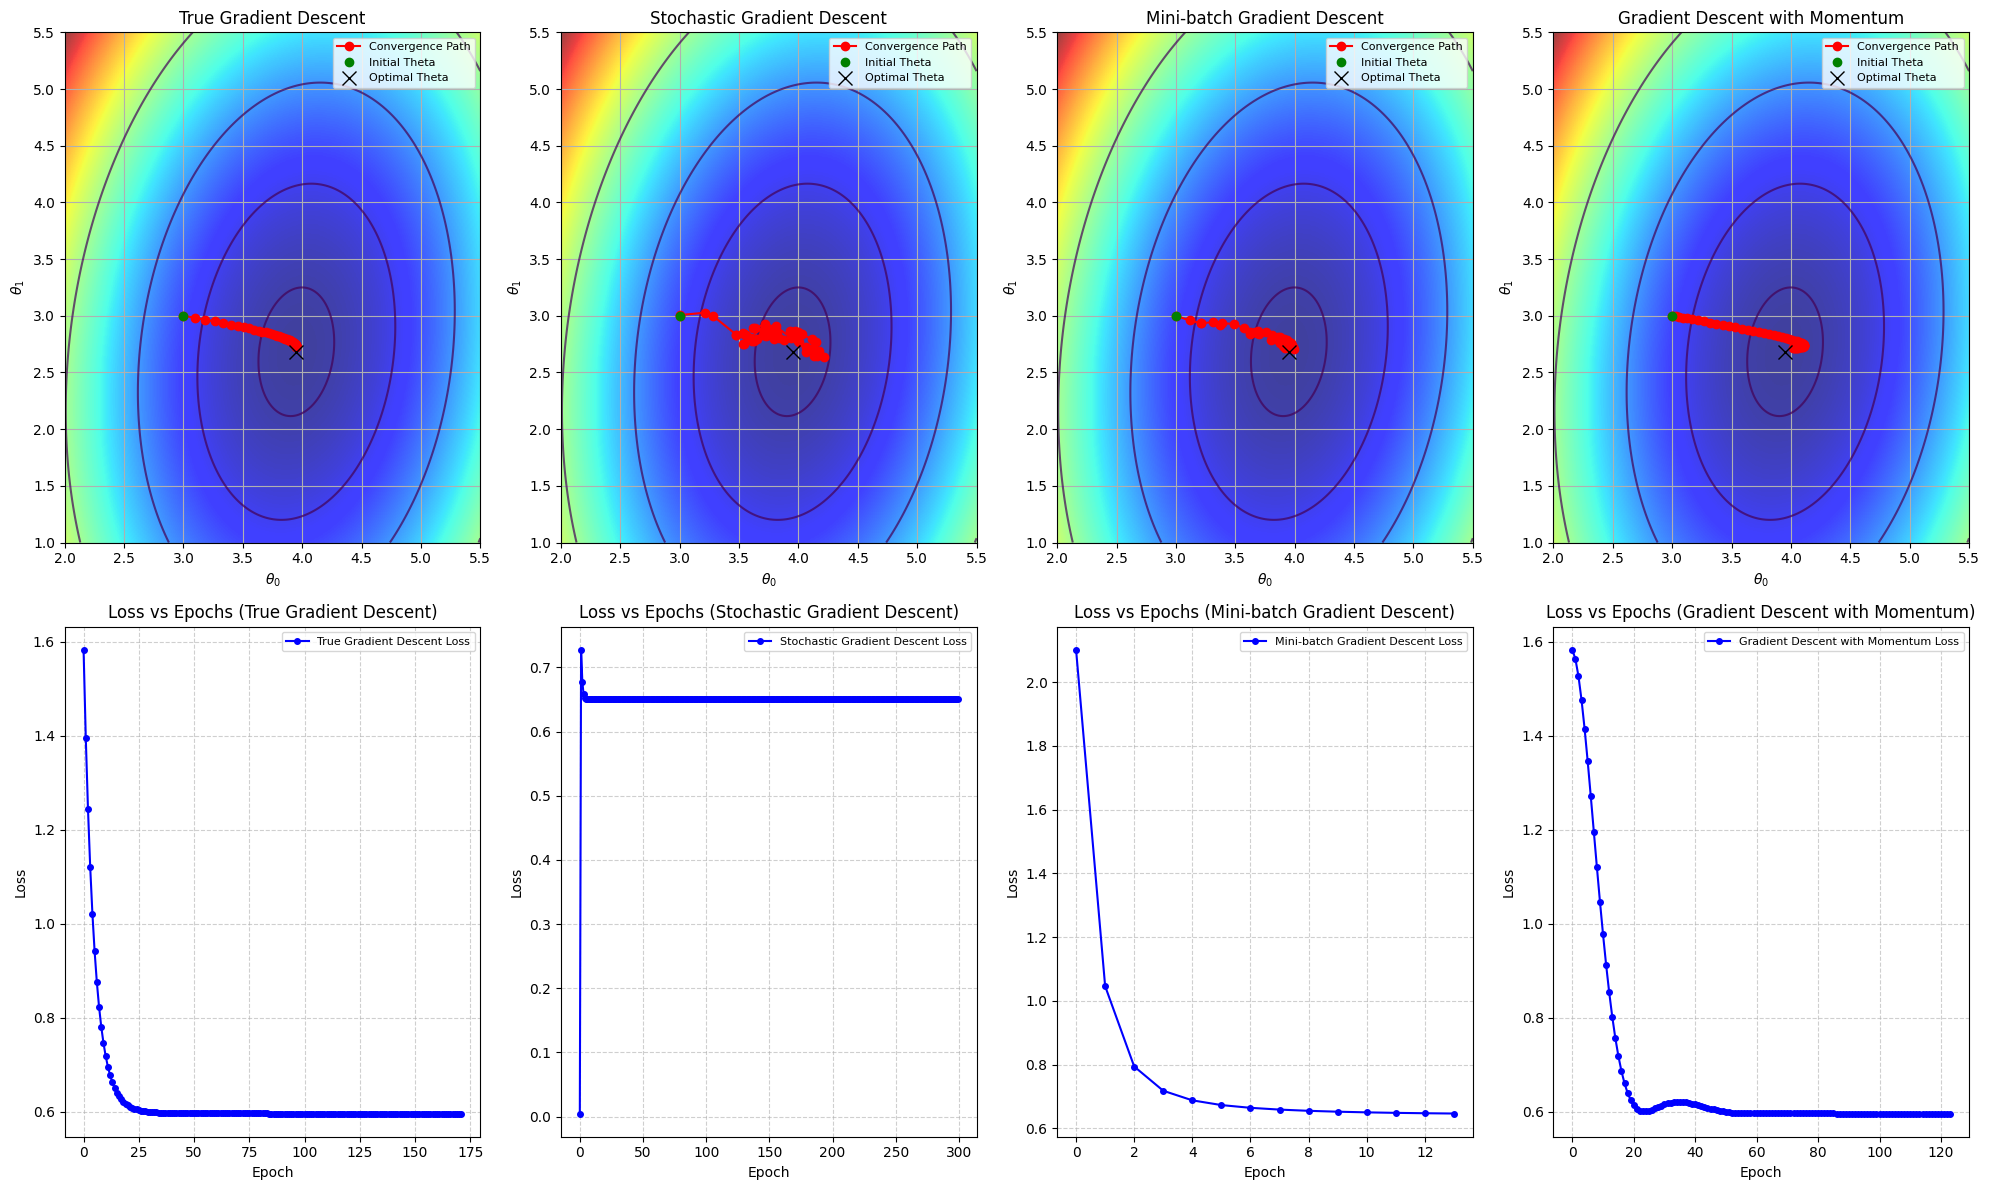

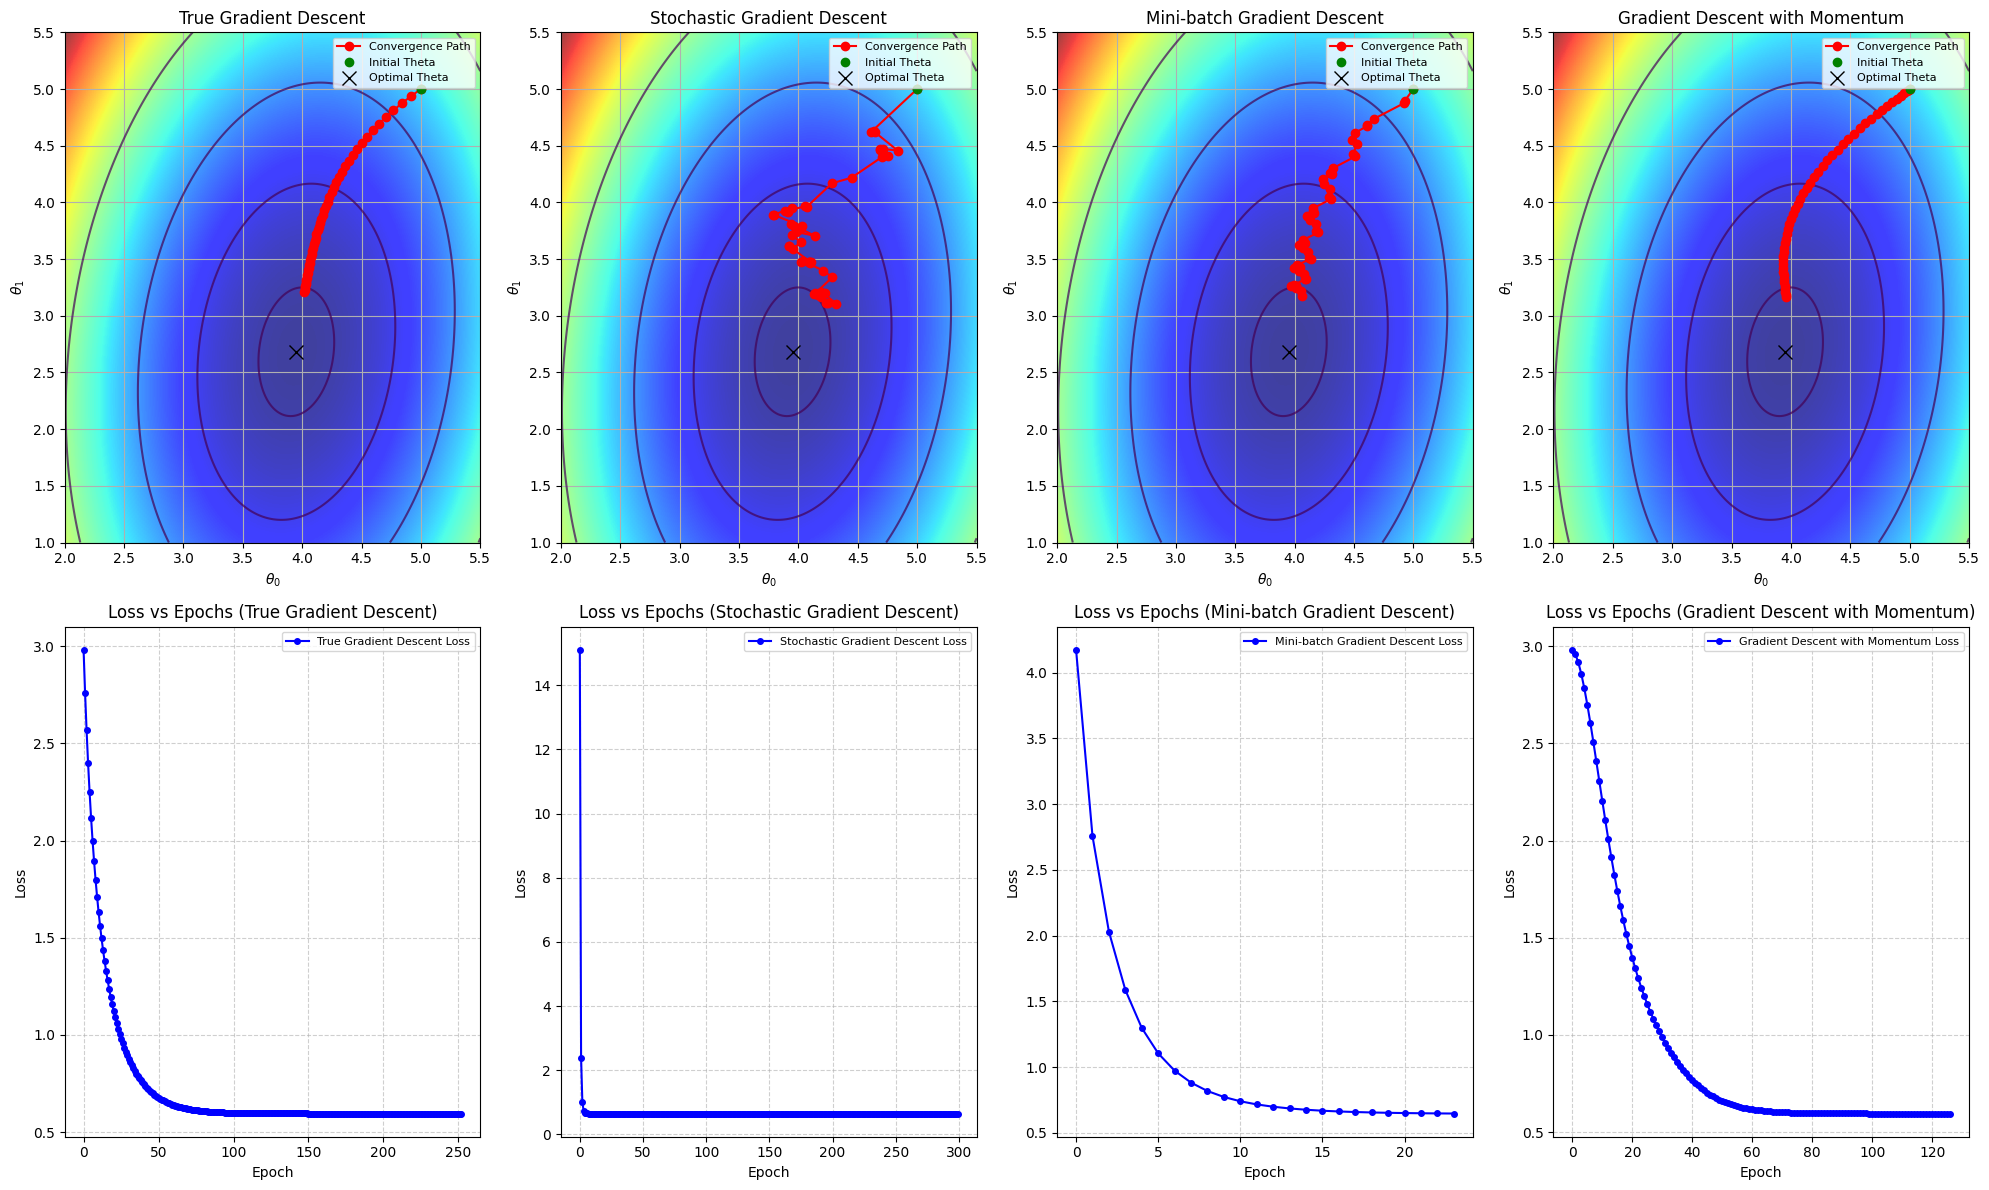

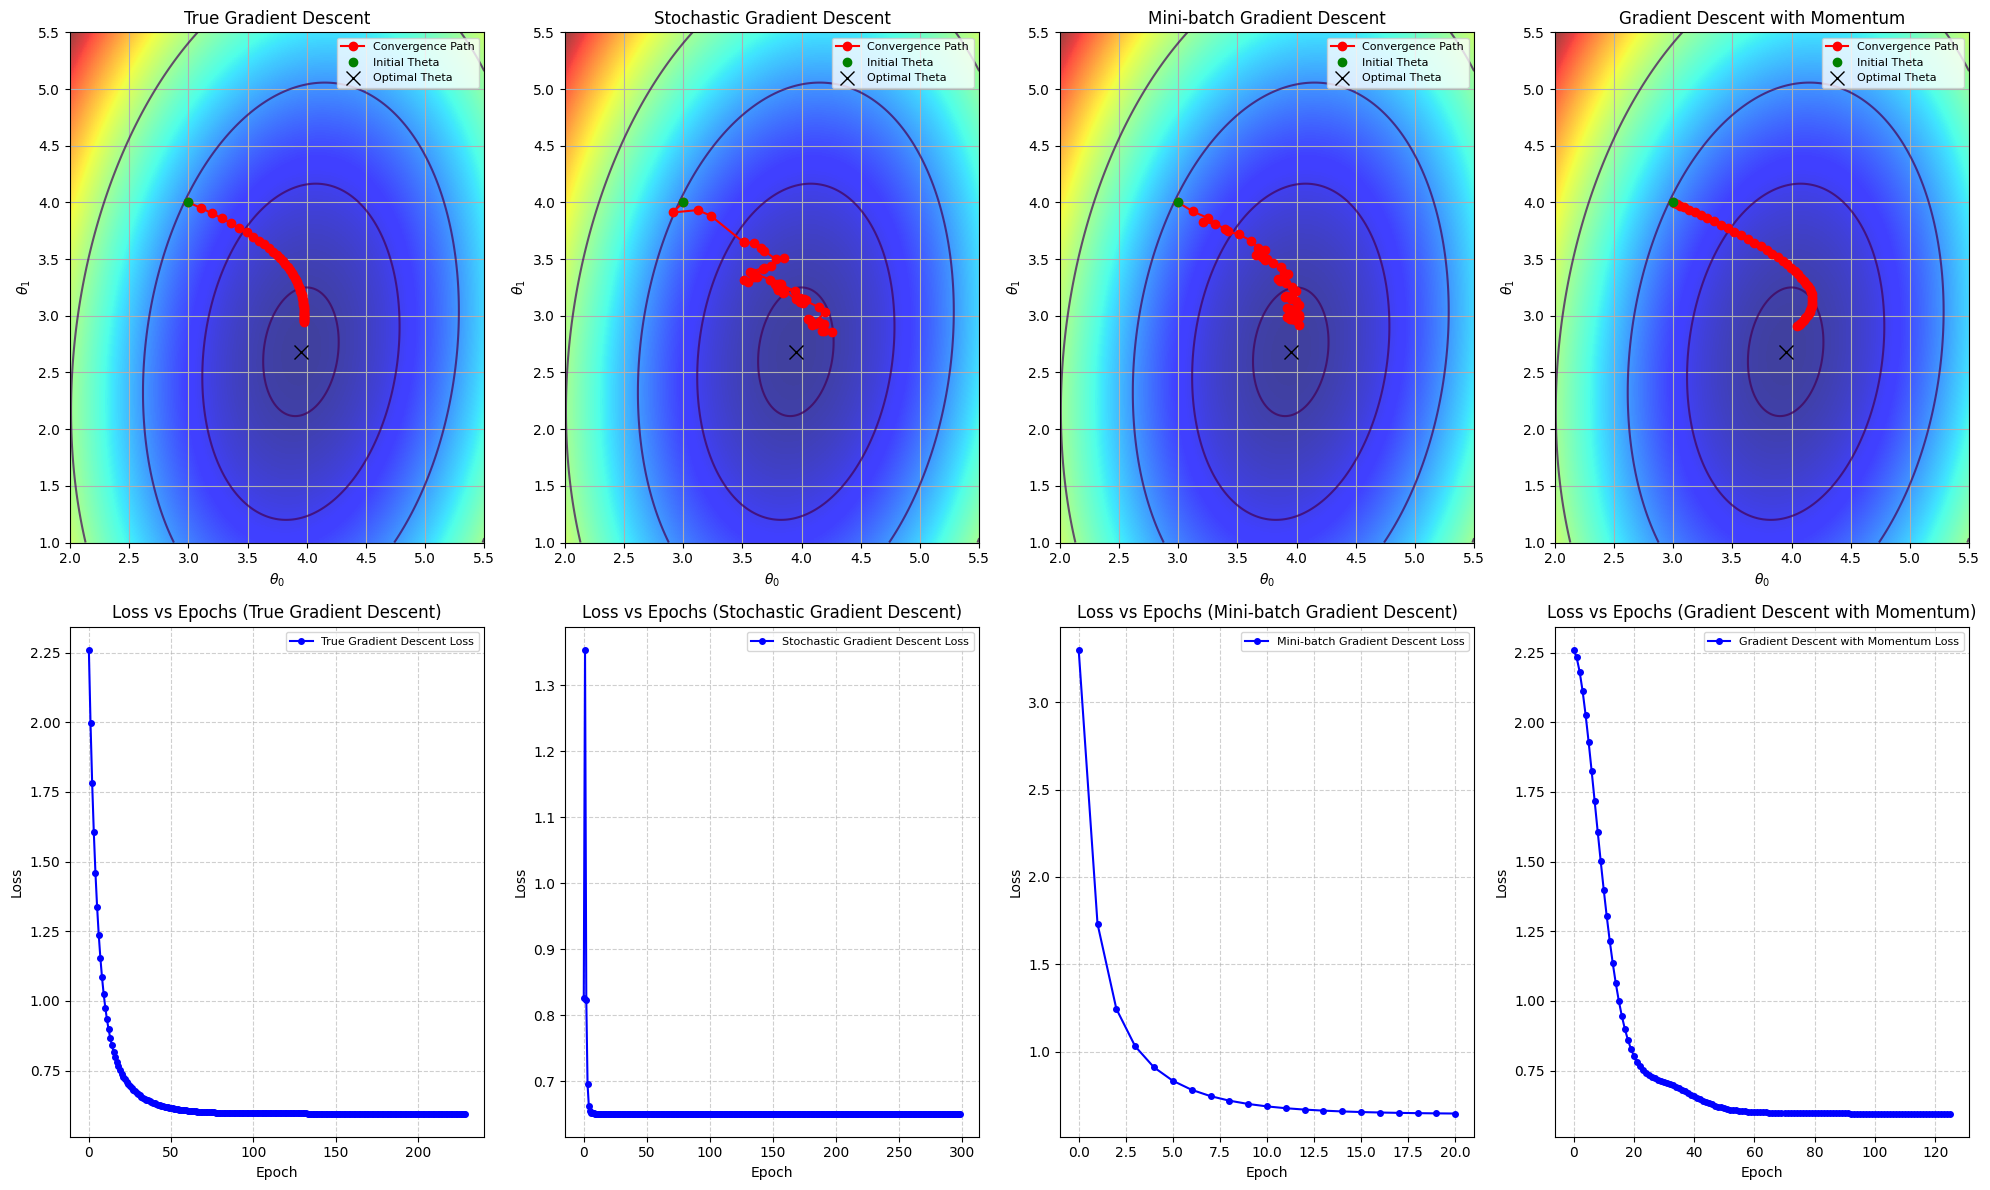

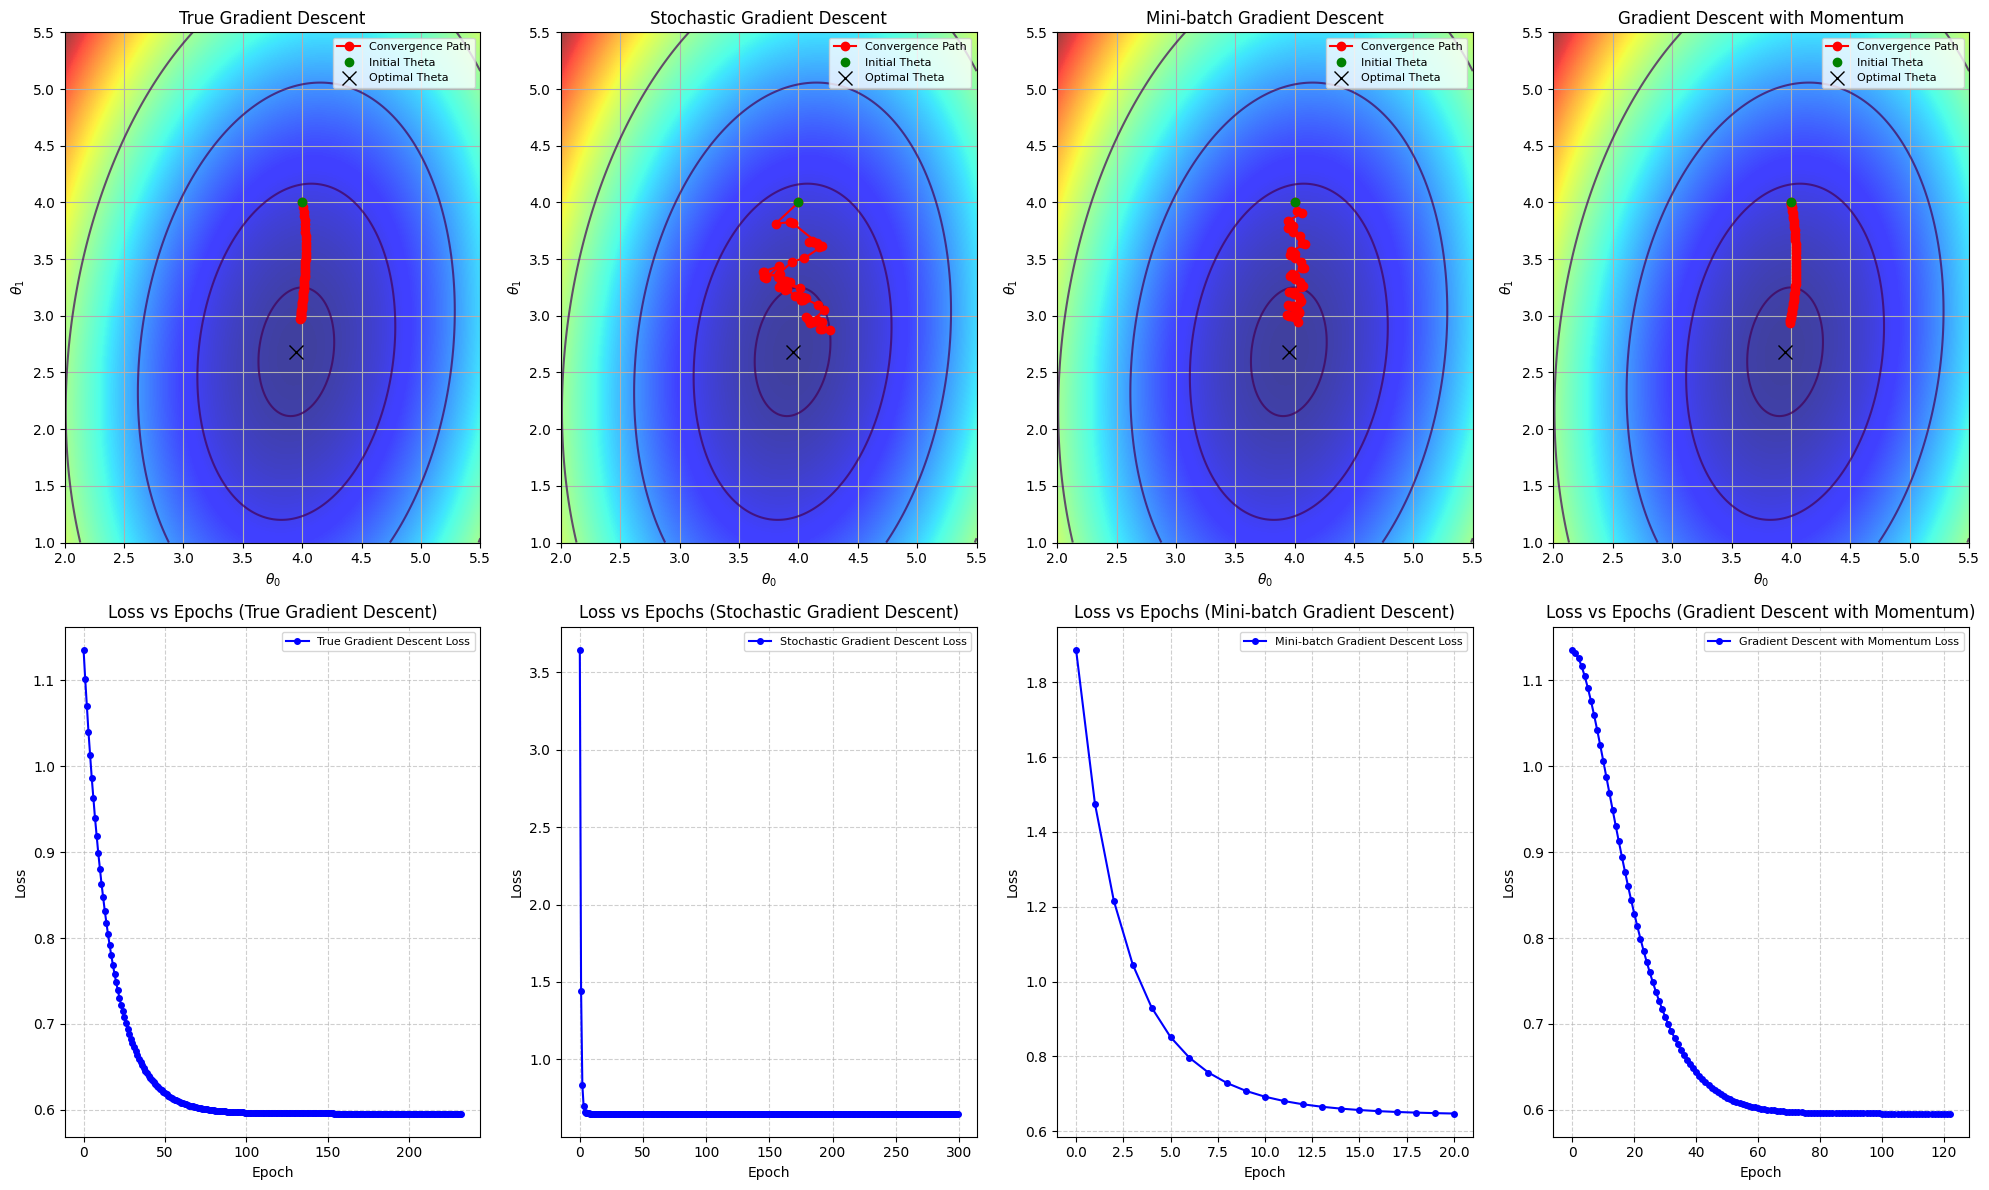

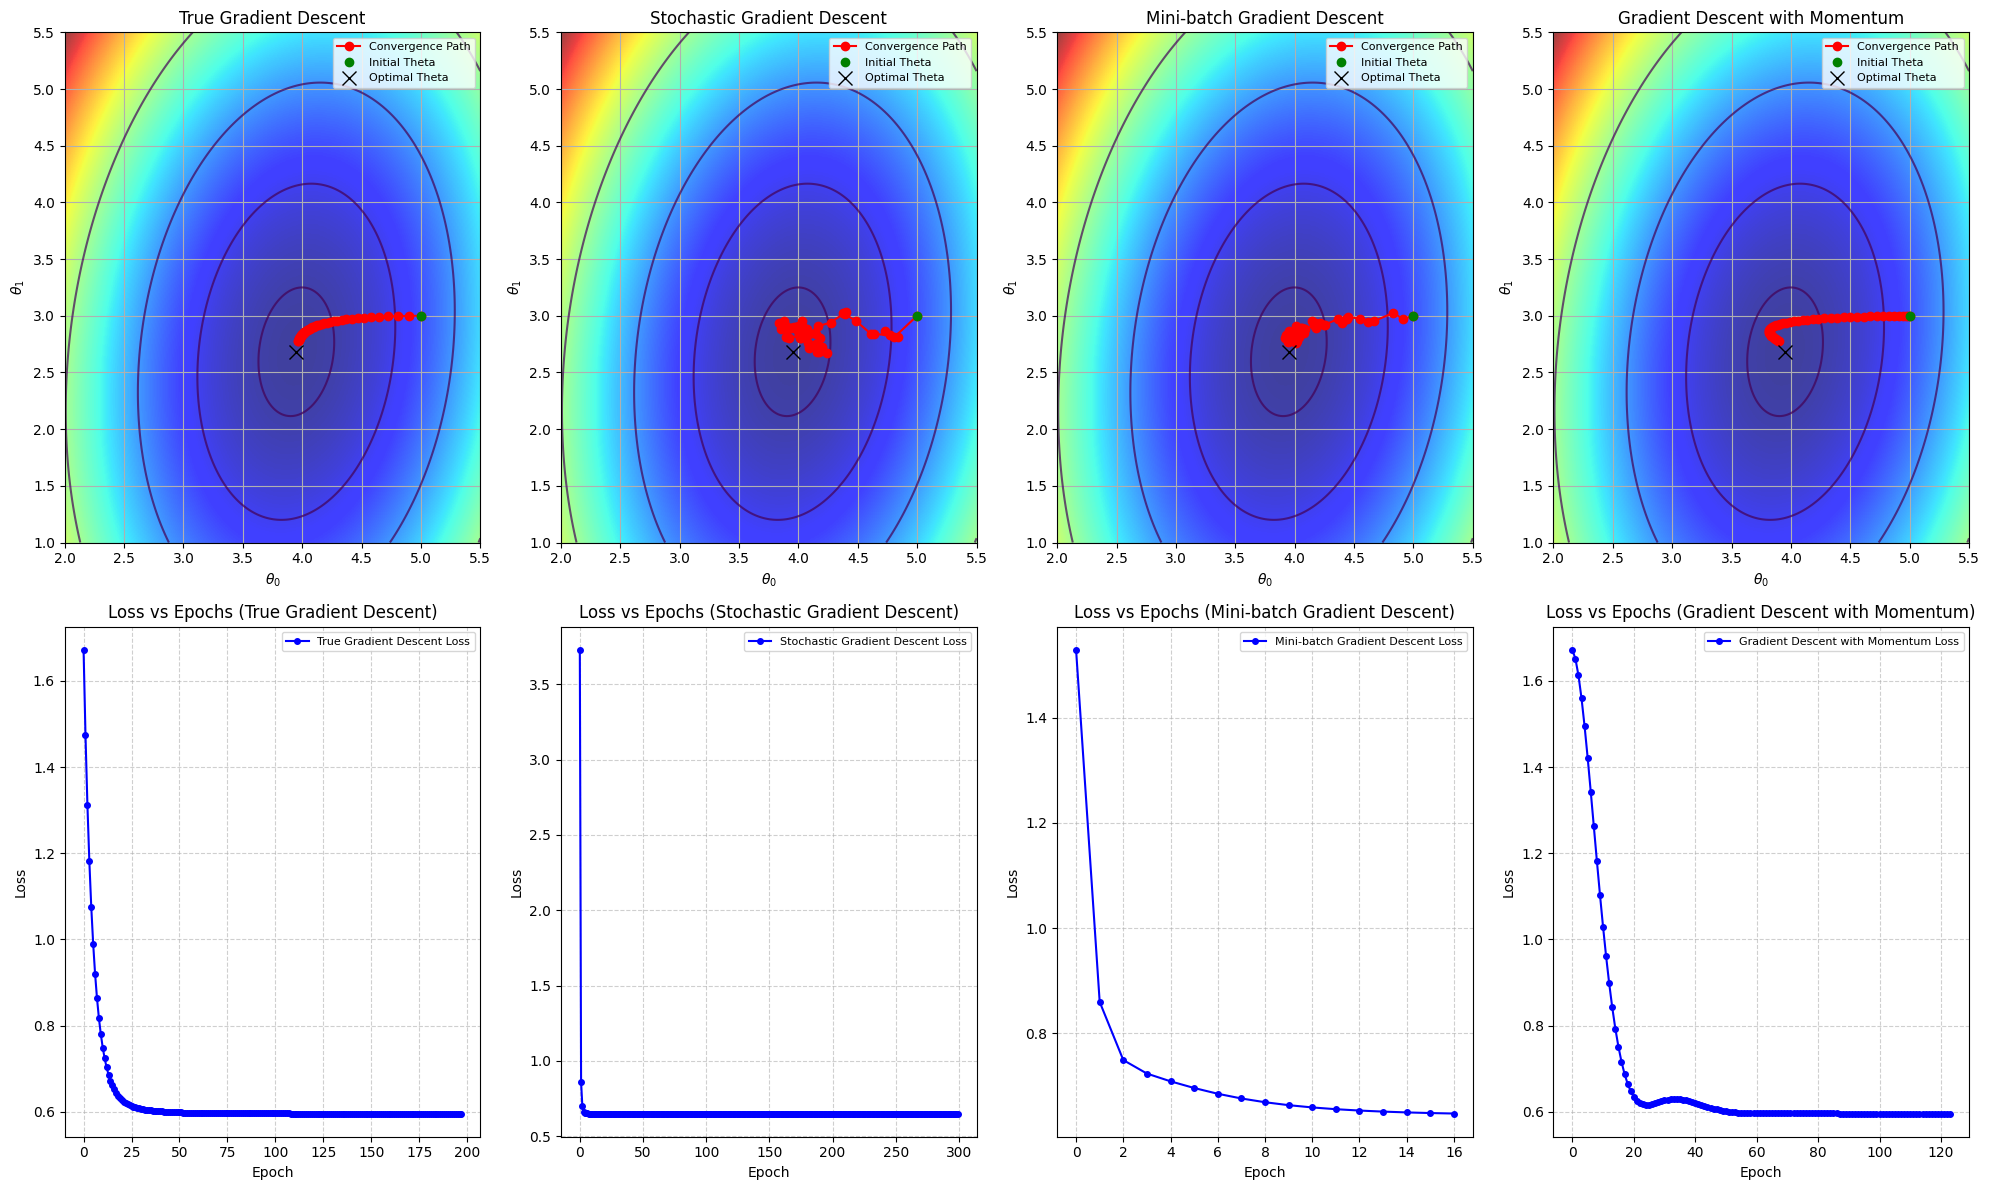

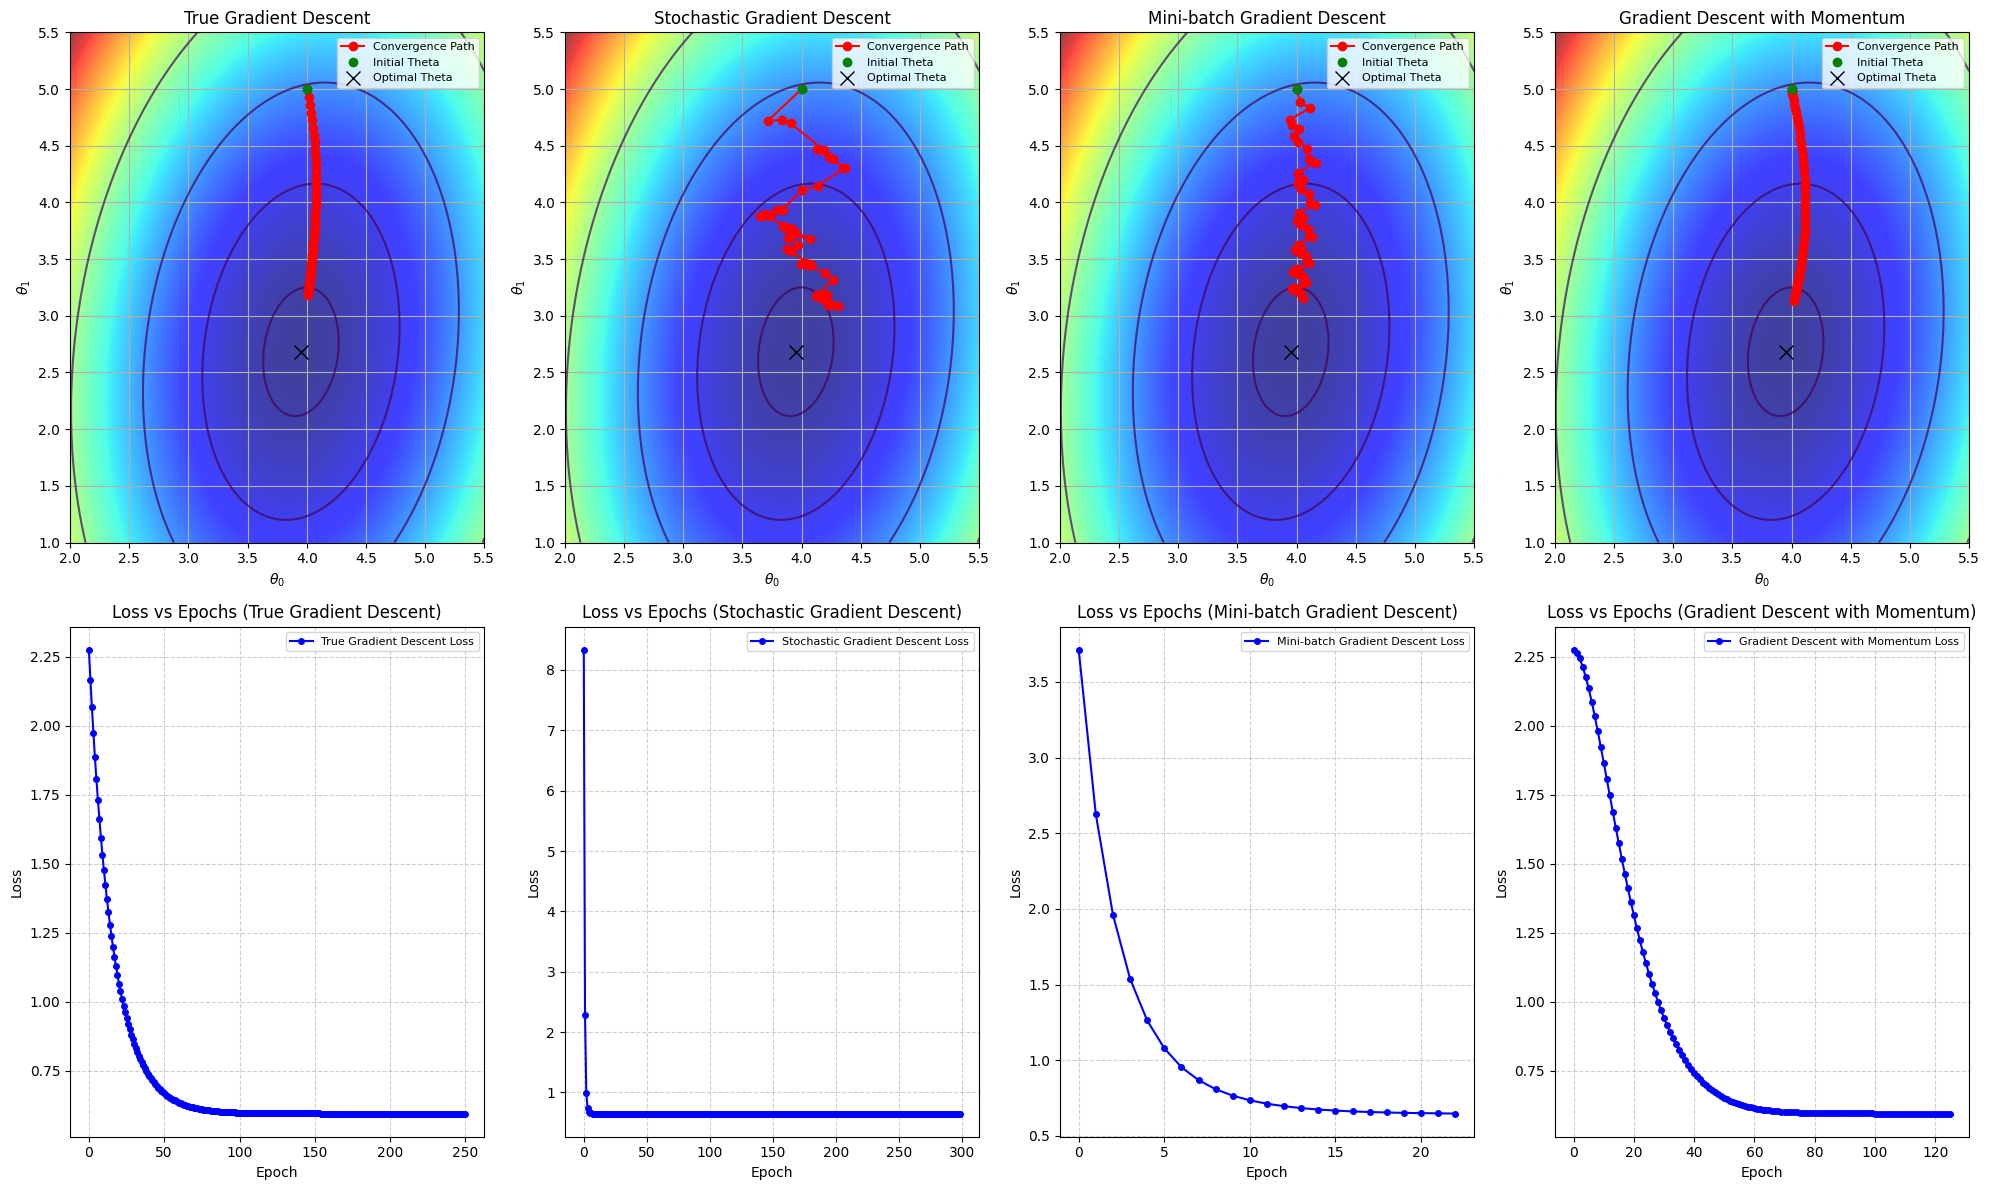

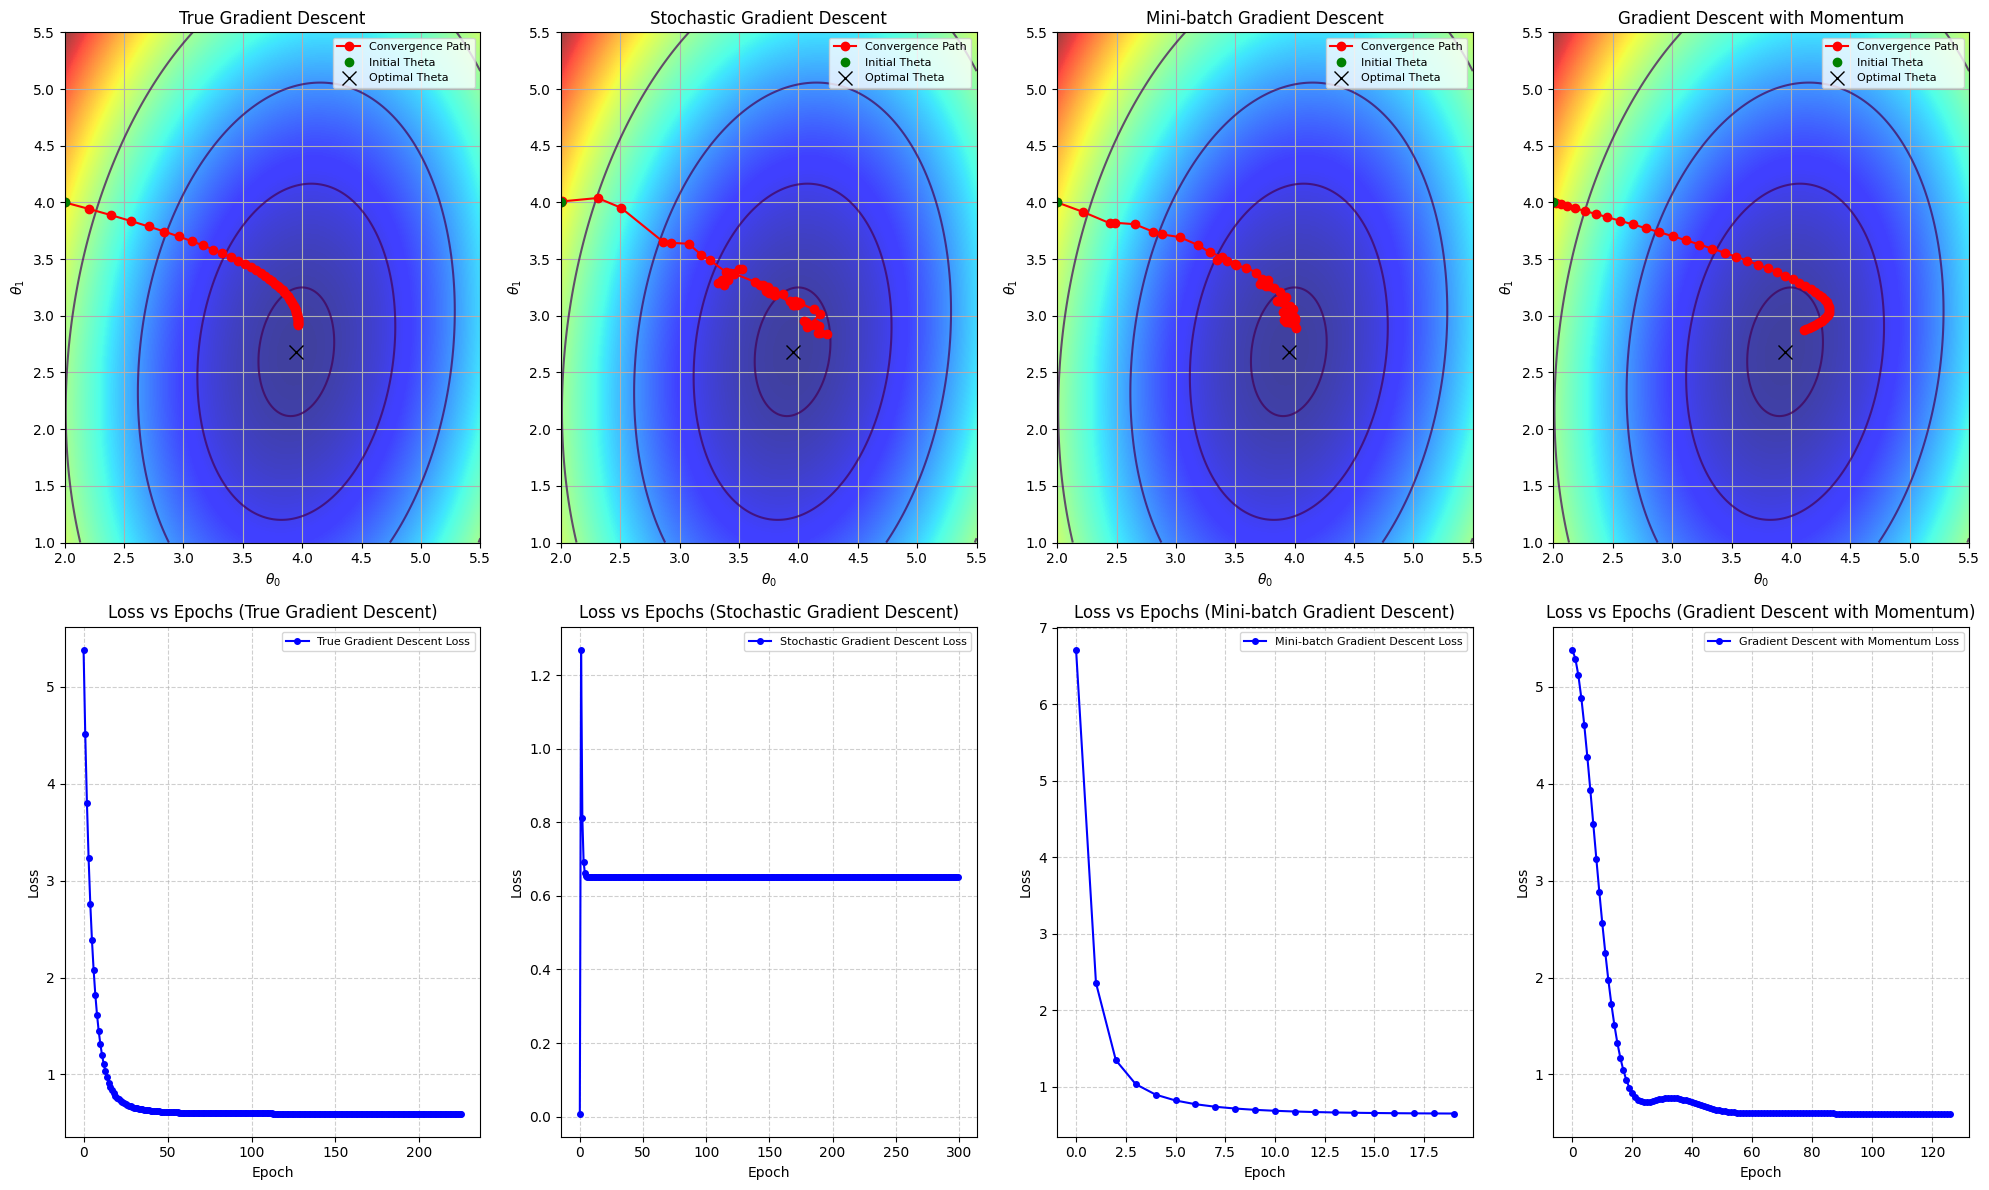

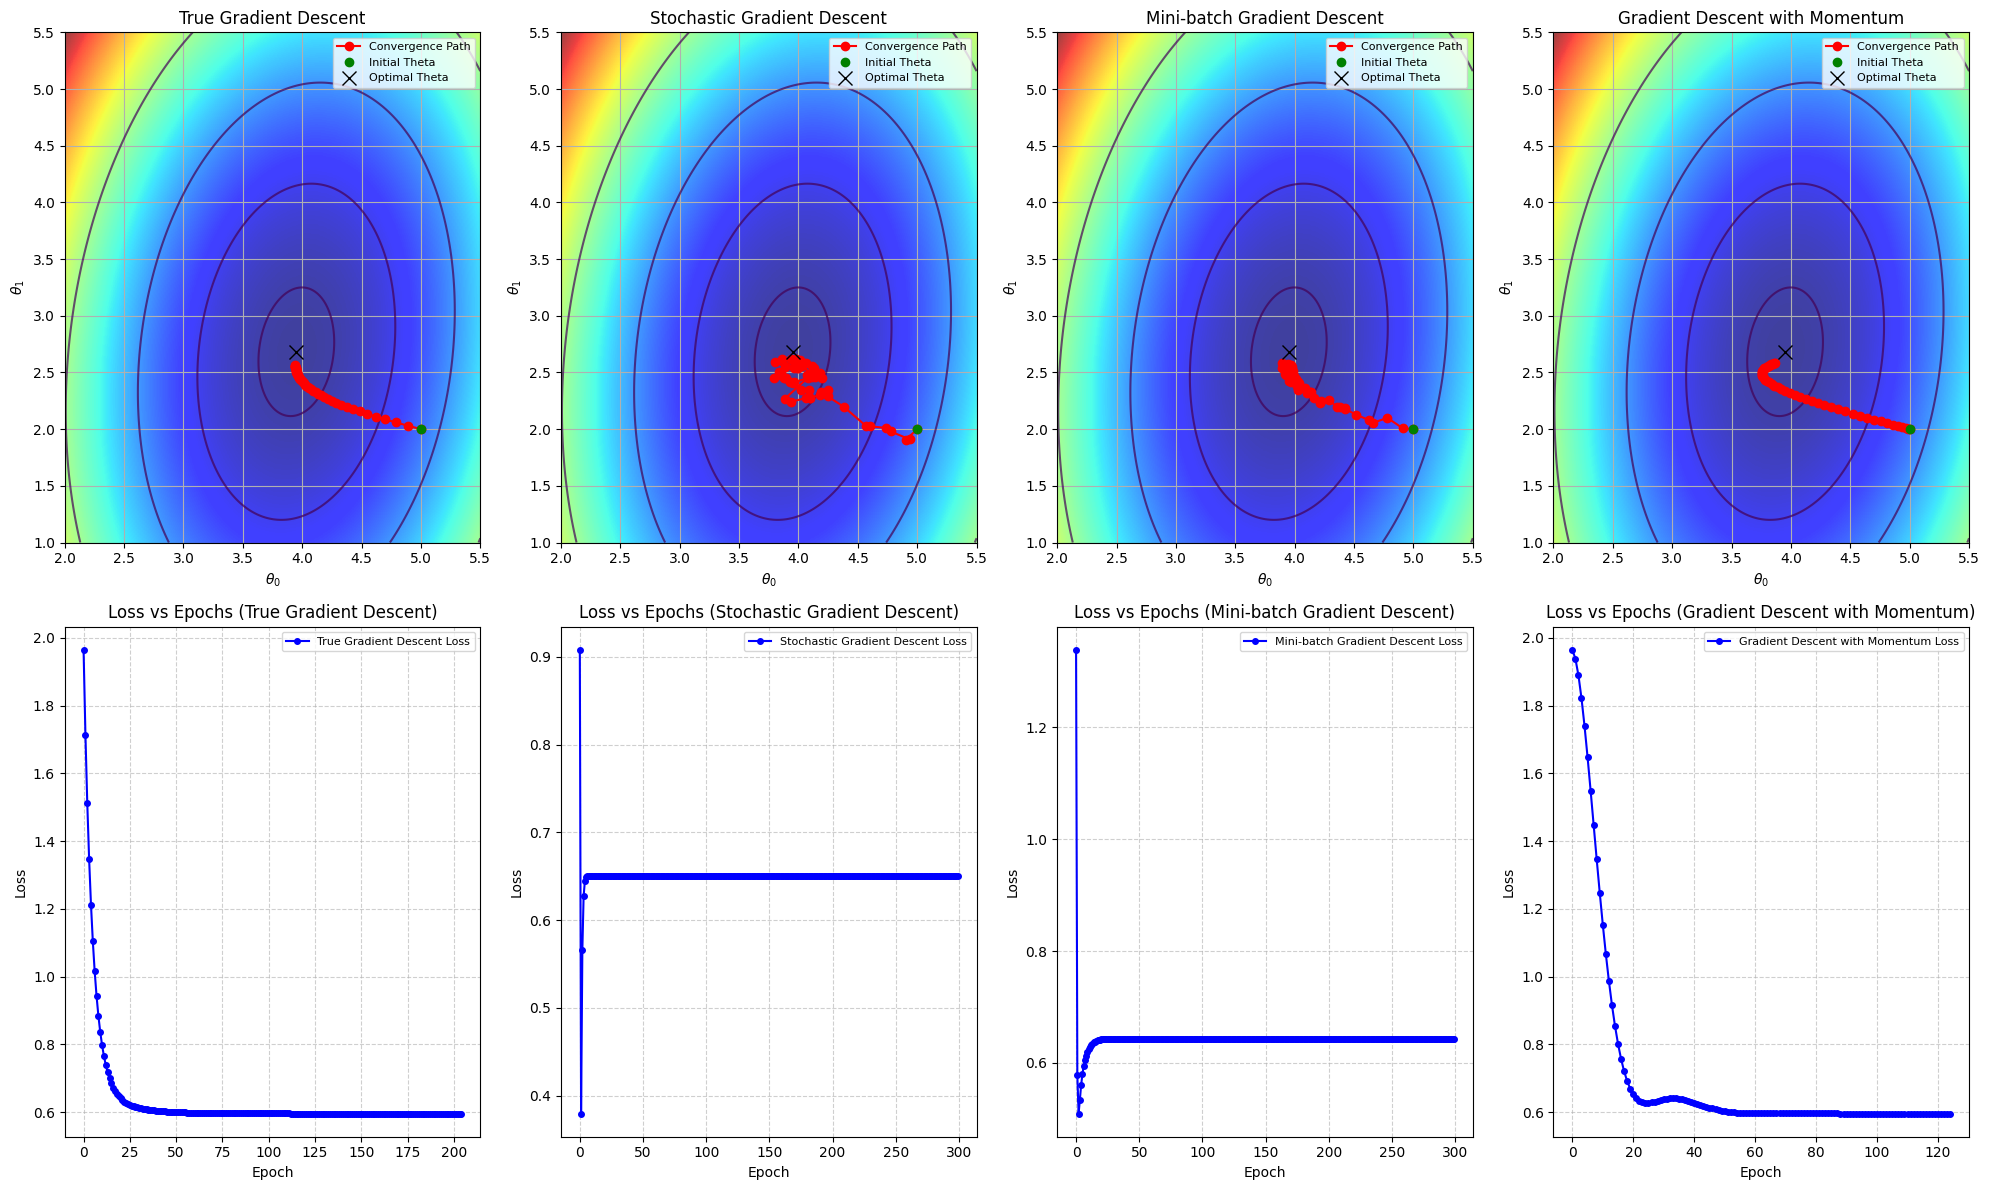

In [26]:
tgd_eps = []
sgd_eps = []
mbgd_eps = []
gdm_eps = []


for i in range(10):
    theta = torch.randint(2,6,(2,),dtype = torch.float32,requires_grad = True)
    
    theta_evolution_tgd,eps_count_tgd,loss_tgd = true_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,optTheta)
    tgd_eps.append(eps_count_tgd)

    theta_evolution_sgd,eps_count_sgd,loss_sgd = stochastic_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,num_samples,optTheta)
    sgd_eps.append(eps_count_sgd)

    theta_evolution_mbgd,batch_count_mgbd,eps_count_mbgd,loss_mbgd =mini_batch_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,num_samples,batch_size,optTheta)
    mbgd_eps.append(eps_count_mbgd)

    theta_evolution_gdm,eps_count_gdm,loss_gdm  =gradient_descent_with_momentum(X, y, theta.clone().detach().requires_grad_(True), learning_rate, epsilon, max_epochs, beta,optTheta)
    gdm_eps.append(eps_count_gdm)
    
    plot_all(X, y, theta_evolution_tgd, theta_evolution_sgd, theta_evolution_mbgd, theta_evolution_gdm,
         loss_tgd, loss_sgd, loss_mbgd, loss_gdm, optTheta)
    